<a href="https://colab.research.google.com/github/ArafatRohan93/PSSP_LSTM/blob/main/PSSP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Kaggle API Upload ------Dont touch-----------
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"arafat93","key":"c248e60f0af40ea871dda0a87be41cb5"}'}

In [ ]:
# ------Dont touch-----------
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d alfrandom/protein-secondary-structure -p /content/drive/My\ Drive/Protein/Kaggle

 85% 33.0M/38.8M [00:02<00:00, 10.8MB/s]
100% 38.8M/38.8M [00:02<00:00, 17.9MB/s]


In [ ]:
!unzip /content/drive/My\ Drive/Protein/Kaggle/protein-secondary-structure.zip -d /content/drive/My\ Drive/Protein/Kaggle/ 

Archive:  /content/drive/My Drive/Protein/Kaggle/protein-secondary-structure.zip
  inflating: /content/drive/My Drive/Protein/Kaggle/2018-06-06-pdb-intersect-pisces.csv  
  inflating: /content/drive/My Drive/Protein/Kaggle/2018-06-06-ss.cleaned.csv  


## Code

# Load Data
To show proof of concept only considering sequences shorter than 32 amino acids. Also experiments suggest to apply a sliding overlapping window of size 3 to the input seqeunces. In the sense of  NLP this artificially creates a corpus consisting of much more different words (>7000 different ngrams compared to 20 amino acids). There has been a lot of research in respresenting protein sequences as sentences of  biological words.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #visualisation
sns.set(color_codes=True)

df = pd.read_csv('/content/drive/My Drive/Protein/Kaggle/2018-06-06-ss.cleaned.csv').sort_values(by=['pdb_id','chain_code'])
print(len(df))
df.head()


393732


,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
124730,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,154,False
138377,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCCCCHHHHH...,165,False
124731,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,154,False
140434,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEECCCCCCCCCHHHHH...,167,False
124732,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,154,False


(393732, 7)


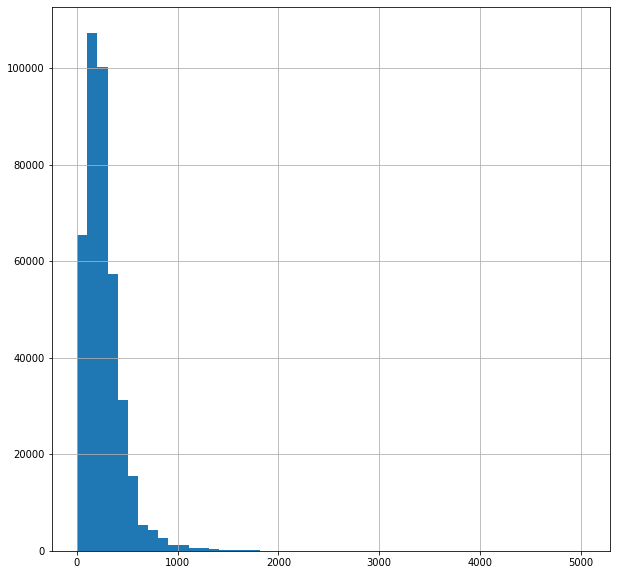

In [8]:
df.len.hist(bins=50,figsize=[10,10],)
print(df.shape)


In [9]:
def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

In [10]:
maxlen_seq = 256
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(input_grams[0])
print(input_seqs[0])
print(target_seqs[0])
print(len(input_seqs))
print(len(target_seqs))

['MVL', 'VLS', 'LSE', 'SEG', 'EGE', 'GEW', 'EWQ', 'WQL', 'QLV', 'LVL', 'VLH', 'LHV', 'HVW', 'VWA', 'WAK', 'AKV', 'KVE', 'VEA', 'EAD', 'ADV', 'DVA', 'VAG', 'AGH', 'GHG', 'HGQ', 'GQD', 'QDI', 'DIL', 'ILI', 'LIR', 'IRL', 'RLF', 'LFK', 'FKS', 'KSH', 'SHP', 'HPE', 'PET', 'ETL', 'TLE', 'LEK', 'EKF', 'KFD', 'FDR', 'DRV', 'RVK', 'VKH', 'KHL', 'HLK', 'LKT', 'KTE', 'TEA', 'EAE', 'AEM', 'EMK', 'MKA', 'KAS', 'ASE', 'SED', 'EDL', 'DLK', 'LKK', 'KKH', 'KHG', 'HGV', 'GVT', 'VTV', 'TVL', 'VLT', 'LTA', 'TAL', 'ALG', 'LGA', 'GAI', 'AIL', 'ILK', 'LKK', 'KKK', 'KKG', 'KGH', 'GHH', 'HHE', 'HEA', 'EAE', 'AEL', 'ELK', 'LKP', 'KPL', 'PLA', 'LAQ', 'AQS', 'QSH', 'SHA', 'HAT', 'ATK', 'TKH', 'KHK', 'HKI', 'KIP', 'IPI', 'PIK', 'IKY', 'KYL', 'YLE', 'LEF', 'EFI', 'FIS', 'ISE', 'SEA', 'EAI', 'AII', 'IIH', 'IHV', 'HVL', 'VLH', 'LHS', 'HSR', 'SRH', 'RHP', 'HPG', 'PGN', 'GNF', 'NFG', 'FGA', 'GAD', 'ADA', 'DAQ', 'AQG', 'QGA', 'GAM', 'AMN', 'MNK', 'NKA', 'KAL', 'ALE', 'LEL', 'ELF', 'LFR', 'FRK', 'RKD', 'KDI', 'DIA', 'IAA'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


# Preprocessing
use preprocessing tools for text from keras to encode input sequence as word rank numbers  and target sequence as one hot. To ensure easy to use training and testing, all sequences are padded with zeros to the maximum sequence length (in our case 32).

In [11]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
# print("input_data[0]")
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
# print(input_data[0])
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')
# print(input_data[0])

# print("target_data[0]")
tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
# print(target_data[0])
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
# print(target_data[0])
target_data = to_categorical(target_data)
# print(target_data[0])
input_data.shape, target_data.shape

((226733, 256), (226733, 256, 4))

# Build Model

In [14]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 4
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 128)          1077888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256, 128)          98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 256, 4)            516       
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


# Train and Evaluate

In [15]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.fit(X_train, y_train, batch_size=128, epochs=2, validation_data=(X_test, y_test), verbose=1)

Epoch 1/2
1063/1063 [==============================] - 1621s 2s/step - loss: 0.4356 - accuracy: 0.8091 - q3_acc: 0.6749 - val_loss: 0.2779 - val_accuracy: 0.8890 - val_q3_acc: 0.8084
Epoch 2/2
1063/1063 [==============================] - 1623s 2s/step - loss: 0.2697 - accuracy: 0.8919 - q3_acc: 0.8132 - val_loss: 0.2412 - val_accuracy: 0.9041 - val_q3_acc: 0.8346


# Results

training
---
Input: MDEADRRLLRRCRLRLVEELQVDQLWDVLLSRELFRPHMIEDIQRAGSGSRRDQARQLIIDLETRGSQALPLFISCLEDTGQDMLASFLRTNRQAAKLSK
Target: CCHHHHHHHHHCHHHHHHHCCCCCCHHHHHHCCCCCHHHHHHHHCCCCCCHHHHHHHHHHHHCCCCCCHHHHHHHHHHHCCCHHHHHHHHHHHCCCCCCC
Result: CCCHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHCCCHHHHHHHHHCCCCCHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHCHHHHHHHHHHHHHHHCCCC


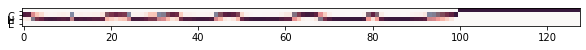

---
Input: TFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGR
Target: CCCCCCCCCCCCCCCHHHCCCCCCHHHHHHHCCCCC
Result: CCCCCCCCCCCCCCCHHHCCCCCCHHHHHHHCCCCC


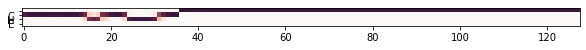

---
Input: RAKMPRALDFSGHTHPVATFQPSRPESVNDLFLCPQKELTRGVRPTPR
Target: CCCCCHHHCCCCCCCCCCEECCCCCCCCCCCEEEECCCCCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCCCECCCCCCCHHHHHHCHHHHCCCCCECCCC


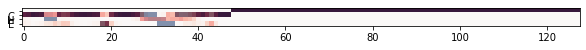

testing
---
Input: AIAPCMQTTHSKMTAGAYTEGPPQPLSAEEKKEIDKRSVYVGNVDYGSTAQDLEAHFSSCGSINRITILCDKFSGHPKGYAYIEFAERNSVDAAVAMDETVFRGRTIKVLPKRTNMPGISSTDR
Target: CCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCEEEEEEECCCCCHHHHHHHHHCCCCEEEEEEEEECCCCCCEEEEEEEECCHHHHHHHHCCCCCEECCEECEEEECCCCCCCCCCCCC
Result: CCCCECCCCHCECEECCCCCCCCCCCCCCCCCCCCCCEEEECCEECCCCCHEEEECCCCCCCCCEEEEEEEEEECCCCEEEEEEEECCCCCCHHHHHHHHHHCCCCEEEEEECCCCCCCCCCCC


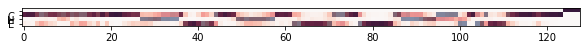

---
Input: GSPEFLGEEDIPREPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEANSRVDSSGRIVTD
Target: CCCCCHHHCCCCCCCEEEEEECCCCCCCEEEEECHHHCCEEEEEECCCCHHHHHCCCCCCEEEEEECCEECCCCCHHHHHHHHHCCCCEEEEEEEECHHHHHCCCCCEEECCCCCEEEC
Result: CCCCCCCCCCCCCCCEEEEEECCCCECCEEEEECCCCCEEEEEEEECCCHHHHHHHCCCCCEEEEEEEEEECCCCHHHHHHHHHHCCCEEEEEEECCCHHHHHHHHCCEEECCCEEEEC


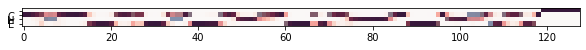

---
Input: GSSGSSGSYYDILGVPKSASERQIKKAFHKLAMKYHPDKNKSPDAEAKFREIAEAYETLSDANRRKEYDTLGHSAFTSGKGQSGPSSG
Target: CCCCCCCCHHHHHCCCCCCCHHHHHHHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHHHHCCHHHHHHHHCCHHHHCCCCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCC


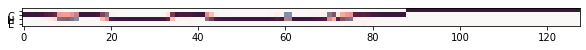

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])